# Simulation Optimsiation using DES model of homeless response system

In [1]:
import datetime
print('Current version of this notebook updated ' + str(datetime.date.today()))

Current version of this notebook updated 2023-12-22


This notebook sets up a solution space to study with the analytical model and the simulation model - checking that an R+S SimOpt algorithm can find the true optimal solution (which we know based on the analytical model). It also looks at some other solution spaces and only studies them with the analytical model - for these solution spaces, a range of different objective functions are explored. 

## Ranking & Selection

First we employ a Ranking & Selection algorithm based on the Kim & Nelson procedure. Details of this procedure can be found in section 9.3.2 (page 247) of 'Foundation and Methods of Stochastic Simulation' - Edition 2 (2021). The Python code for this procedure is found in the ranking_and_selection.py file in the GitHub repository. Below we import this module, and some others

In [2]:
# modules from this repository
import ranking_and_selection as rs
import simulation_model as sim
import queueing_model as qm

# external packages
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import json

### Testing using Inventory System

In order to test our KN procedure, we test it on a simulation model which has already been analysed using the KN algorithm in STOR-606 module - this is an $(s,S)$ inventory system where stock is replenished to a level of $S$ when it reaches $s$. 

In [3]:
solutions = [i for i in range(1600)]
k=np.array([i for i in range(1600)])

def simulate(solution):
    # one replication of simulating the cost of the inventory policy
    out=rs.InventorySystem(solution)[0]
    return out

In [4]:
random.seed(1)
opt_sols = []
for i in range(0):
    spc = rs.SolutionSpace(solutions)
    spc.optimise_rs(0.05, 50, 1, simulate, False, False)
    s,S = rs.get_sS_system(k[spc.active][0])
    opt_sols.append((s,S))

In [5]:
print('(s,S) for the optimal solution found at each iteration of the algorithm')
print(opt_sols)

(s,S) for the optimal solution found at each iteration of the algorithm
[]


The above illustrates (if you change the 'range' over which the algorithm runs above from 0 to something) that this KN algorithm can return different solutions when it is run at different times (i.e. with different starting seeds) - this is likely due to the difference between the true best and other good solutions being less than the 'delta' indiffference zone parameter used when running the algorithm above. 

In [6]:
# Opening JSON file
with open('data_as_is.json') as json_file:
    data_as_is = json.load(json_file)
    
# Opening JSON file
with open('data_as_is_simulation.json') as json_file:
    data_as_is_simulation = json.load(json_file)
    
# Opening JSON file
with open('data_as_is_analytical.json') as json_file:
    data_as_is_analytical = json.load(json_file)

### Developing a discrete solution space for the homeless response system

In [7]:
# solution space constraints
build_rate_options = {'housing' : [12, 24], 'shelter' : [12,24]}
annual_budget = 36
accommodation_budgets = {'housing' : 120, 'shelter' : 120}
costs = {'housing': 1, 'shelter': 1}
build_rate_length_years = 6

# generate solution space
sols = rs.generate_solution_space(build_rate_options, 
                                  annual_budget, 
                                  accommodation_budgets, 
                                  costs, 
                                  build_rate_length_years)

sols = rs.keep_max_budget(sols, costs, annual_budget)

Below we initialise a solution space object with the solutions we have generated

In [8]:
spc = rs.SolutionSpace(sols)

### Analytic treatment of the solution space

In [10]:
# model analytically
outputs = []
for s in range(len(sols)):
    # create instance of queue
    q = qm.queue(data_as_is['arrival_rates'], 
                 data_as_is['service_mean'], 
                 data_as_is['initial_capacity'], 
                 sols[s], 
                 data_as_is['initial_demand'], 
                 data_as_is_analytical['max_in_system'],
                 data_as_is['time_btwn_changes_in_build_rate'],
                 data_as_is['time_btwn_building'])

    q.model_dynamics(data_as_is['analysis_horizon'],
                     data_as_is_analytical['delta_t'])
    outputs.append(q.num_unsheltered_avg)
    print('done ' + str(s) + ' of ' + str(len(sols)))

done 0 of 50


done 1 of 50


done 2 of 50


done 3 of 50


done 4 of 50


done 5 of 50


done 6 of 50


done 7 of 50


done 8 of 50


done 9 of 50


done 10 of 50


done 11 of 50


done 12 of 50


done 13 of 50


done 14 of 50


done 15 of 50


done 16 of 50


done 17 of 50


done 18 of 50


done 19 of 50


done 20 of 50


done 21 of 50


done 22 of 50


done 23 of 50


done 24 of 50


done 25 of 50


done 26 of 50


done 27 of 50


done 28 of 50


done 29 of 50


done 30 of 50


done 31 of 50


done 32 of 50


done 33 of 50


done 34 of 50


done 35 of 50


done 36 of 50


done 37 of 50


done 38 of 50


done 39 of 50


done 40 of 50


done 41 of 50


done 42 of 50


done 43 of 50


done 44 of 50


done 45 of 50


done 46 of 50


done 47 of 50


done 48 of 50


done 49 of 50


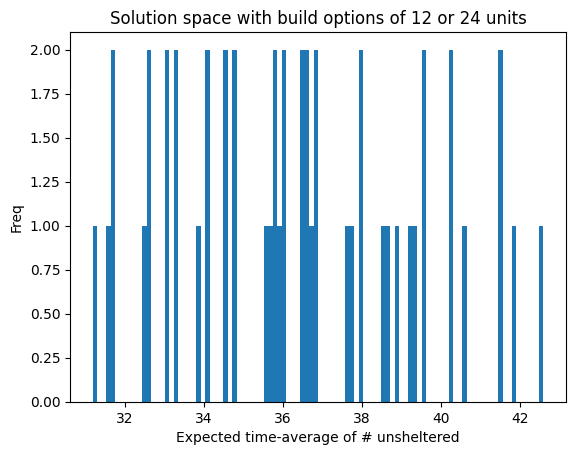

In [ ]:
# Creating histogram 
fig, ax = plt.subplots(1, 1) 
ax.hist(outputs, 100) 
  
# Set title 
ax.set_title("Solution space with build options of 12 or 24 units") 
    
# adding labels 
ax.set_xlabel('Expected time-average of # unsheltered') 
ax.set_ylabel('Freq') 

plt.show()

In [12]:
# Dataframe of analytic results
my_list = []
for i in range(len(sols)):
    my_dict = {}
    for index, element in enumerate(sols[i]['housing']):
        my_dict[index] = element
    my_dict[6] = " "
    for index, element in enumerate(sols[i]['shelter']):
        my_dict[index+7] = element
    my_dict[13] = outputs[i]
    my_list.append(my_dict)
df_analytic = pd.DataFrame.from_dict(my_list)
df_analytic.columns = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6', ' ', 'sh1', 'sh2', 'sh3', 'sh4', 'sh5', 'sh6', 'c']

In [22]:
# Looking at the improvements in the objective func given by a change in each dimension separately
low_val = 12
dims_all = ['h1','h2','h3','h4','h5','h6','sh1','sh2','sh3','sh4','sh5','sh6']
list_imprv = [] # data on improvements
for dim in dims_all:
    for i in df_analytic[df_analytic[dim]==low_val].index.tolist():
        value_base = df_analytic.iloc[i]['c']
        conditions = dim + '''!=''' + str(low_val)
        for dim_compare in [dims_all[j] for j in range(len(dims_all)) if dims_all[j]!=dim]:
            conditions = conditions + ''' & ''' + dim_compare + '==' + str(df_analytic.iloc[i][dim_compare])
        df_analytic_with_conditions = df_analytic.query(conditions).reset_index(drop=True)
        if len(df_analytic_with_conditions) > 0:
            value_improve = df_analytic_with_conditions['c'][0]
            improvement = value_base - value_improve
            improvement = {'dim': dim,
                           'imprv': improvement}
            list_imprv.append(improvement)
        
df_imprv = pd.DataFrame.from_dict(list_imprv)

In [24]:
# This will only work if we don't restrict the solution space to solutions where the budget is maxed out. 
# df_imprv_summary = df_imprv.groupby('dim').mean().reset_index()
# df_imprv_summary

Above we see that building housing early is the most favourable option given this setup - this makes intuitive sense given this set up because there is no difference in cost built in to favour one accommodation type over the other. Extra housing has the ability to begin service time for someone in shelter and also take someone out of the unsheltered queue and into shelter. Extra shelter only has the ability to do the latter. We might in future consider a service time in housing which is dependent on the time spent in shelter - because we might consider time in shelter as 'partial service'. 

Furthermore - it is also intuitive that building more housing or shelter units the earlier the better is most favourable - since this setup favours improvements to the unsheltered queue equally at all times, and early builds have an effect over a longer period of time. 

In [25]:
# Look at the difference between true best and true second-best 
df_analytic_sorted = df_analytic.sort_values('c').reset_index(drop=True)
indiff = df_analytic_sorted.iloc[1, df_analytic_sorted.columns.get_loc('c')] - df_analytic_sorted.iloc[0, df_analytic_sorted.columns.get_loc('c')]

### Sim Opt treatment of solution space

In [27]:
random.seed(12345)
initial_reps = 100
spc = rs.SolutionSpace(sols)
spc.run_initial_reps(initial_reps,
                     sim.simulate_as_is,
                     data_as_is = data_as_is, 
                     data_as_is_simulation = data_as_is_simulation)

In [28]:
optim_sols = []
k=1000
for i in range(k):
    spc.optimise_rs(0.5, 
                    initial_reps, 
                    indiff, 
                    sim.simulate_as_is, 
                    False, 
                    False, 
                    data_as_is = data_as_is, 
                    data_as_is_simulation = data_as_is_simulation)
    optim_sols.append(np.array(spc.solutions)[spc.active][0].solution)
    print('done ' + str(i) + str(np.array(spc.solutions)[spc.active][0].solution) + ' at time ' + str(datetime.datetime.now()))

starting routine at time  2023-12-22 12:27:04.423853


start iteration 109 with 49 active solutions out of initial 50 at time 2023-12-22 12:27:46.939247


start iteration 111 with 48 active solutions out of initial 50 at time 2023-12-22 12:27:57.561524


start iteration 114 with 47 active solutions out of initial 50 at time 2023-12-22 12:28:12.753262


start iteration 119 with 46 active solutions out of initial 50 at time 2023-12-22 12:28:37.182277


start iteration 124 with 45 active solutions out of initial 50 at time 2023-12-22 12:29:01.778177


start iteration 131 with 44 active solutions out of initial 50 at time 2023-12-22 12:29:34.704949


start iteration 136 with 43 active solutions out of initial 50 at time 2023-12-22 12:29:58.080180


start iteration 137 with 42 active solutions out of initial 50 at time 2023-12-22 12:30:02.724419


start iteration 138 with 41 active solutions out of initial 50 at time 2023-12-22 12:30:07.150009


start iteration 141 with 40 active solutions out of initial 50 at time 2023-12-22 12:30:20.694807


start iteration 150 with 39 active solutions out of initial 50 at time 2023-12-22 12:30:58.811063


start iteration 154 with 38 active solutions out of initial 50 at time 2023-12-22 12:31:15.687332


start iteration 158 with 37 active solutions out of initial 50 at time 2023-12-22 12:31:31.886203


start iteration 159 with 36 active solutions out of initial 50 at time 2023-12-22 12:31:35.843314


start iteration 164 with 35 active solutions out of initial 50 at time 2023-12-22 12:31:55.131368


start iteration 170 with 34 active solutions out of initial 50 at time 2023-12-22 12:32:17.438441


start iteration 186 with 33 active solutions out of initial 50 at time 2023-12-22 12:33:15.564223


start iteration 216 with 32 active solutions out of initial 50 at time 2023-12-22 12:35:02.919120


start iteration 223 with 31 active solutions out of initial 50 at time 2023-12-22 12:35:26.736899


start iteration 224 with 30 active solutions out of initial 50 at time 2023-12-22 12:35:30.080607


start iteration 228 with 29 active solutions out of initial 50 at time 2023-12-22 12:35:43.011019


start iteration 230 with 28 active solutions out of initial 50 at time 2023-12-22 12:35:49.251369


start iteration 231 with 27 active solutions out of initial 50 at time 2023-12-22 12:35:52.165869


start iteration 240 with 26 active solutions out of initial 50 at time 2023-12-22 12:36:18.746387


start iteration 242 with 25 active solutions out of initial 50 at time 2023-12-22 12:36:24.368165


start iteration 244 with 24 active solutions out of initial 50 at time 2023-12-22 12:36:29.595091


start iteration 254 with 23 active solutions out of initial 50 at time 2023-12-22 12:36:55.077182


start iteration 258 with 22 active solutions out of initial 50 at time 2023-12-22 12:37:05.163385


start iteration 265 with 21 active solutions out of initial 50 at time 2023-12-22 12:37:22.129235


start iteration 267 with 20 active solutions out of initial 50 at time 2023-12-22 12:37:26.730544


start iteration 296 with 19 active solutions out of initial 50 at time 2023-12-22 12:38:31.052748


start iteration 306 with 18 active solutions out of initial 50 at time 2023-12-22 12:38:52.400946


start iteration 336 with 17 active solutions out of initial 50 at time 2023-12-22 12:39:52.338497


start iteration 350 with 16 active solutions out of initial 50 at time 2023-12-22 12:40:18.741853


start iteration 364 with 15 active solutions out of initial 50 at time 2023-12-22 12:40:43.594290


start iteration 382 with 14 active solutions out of initial 50 at time 2023-12-22 12:41:13.490666


start iteration 384 with 13 active solutions out of initial 50 at time 2023-12-22 12:41:16.427844


start iteration 398 with 12 active solutions out of initial 50 at time 2023-12-22 12:41:36.785119


start iteration 415 with 11 active solutions out of initial 50 at time 2023-12-22 12:41:59.274351


start iteration 426 with 10 active solutions out of initial 50 at time 2023-12-22 12:42:12.925960


start iteration 440 with 9 active solutions out of initial 50 at time 2023-12-22 12:42:28.949345


start iteration 533 with 8 active solutions out of initial 50 at time 2023-12-22 12:44:01.920152


start iteration 679 with 7 active solutions out of initial 50 at time 2023-12-22 12:46:11.694309


start iteration 714 with 6 active solutions out of initial 50 at time 2023-12-22 12:46:38.790663


start iteration 739 with 5 active solutions out of initial 50 at time 2023-12-22 12:46:55.572918


start iteration 924 with 4 active solutions out of initial 50 at time 2023-12-22 12:48:39.412587


start iteration 2543 with 3 active solutions out of initial 50 at time 2023-12-22 13:00:45.793869


start iteration 3628 with 2 active solutions out of initial 50 at time 2023-12-22 13:06:52.177471


done 0{'housing': [24, 24, 24, 24, 12, 12], 'shelter': [12, 12, 12, 12, 24, 24]} at time 2023-12-22 13:08:01.922799


In [29]:
(17*24*60)/40


612.0

We next set a seed and then look for an optimal solution using the KN algorithm. A line of text is printed below whenever solutions are removed from the candidate list by the algorithm. We use the true difference between best and second-best solutions as the indifference zone parameter, and we use an alpha of 0.05 - leading to a lower bound of 95% confidence in what we find. 

In [15]:
random.seed(1)
spc.optimise_rs(0.05, 
                100, 
                indiff, 
                sim.simulate_as_is, 
                True, 
                False, 
                data_as_is = data_as_is, 
                data_as_is_simulation = data_as_is_simulation)

The details of the optimal solution are given below, followed by the following 20 solutions in decreasing order of the iteration number at which the KN algorithm removed them from the candidate list. 

In [16]:
# create dataframe of sim opt results
my_list = []
for i in range(len(sols)):
    my_dict = {}
    for index, element in enumerate(sols[i]['housing']):
        my_dict[index] = element
    for index, element in enumerate(sols[i]['shelter']):
        my_dict[index+6] = element
    my_dict[12] = spc.eliminate[i]
    my_dict[13] = np.mean(spc.costs[i])
    my_dict[14] = np.var(spc.costs[i])
    my_list.append(my_dict)
df_sim = pd.DataFrame.from_dict(my_list)
df_sim.columns = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'sh1', 'sh2', 'sh3', 'sh4', 'sh5', 'sh6', 'iter_elim', 'sim_mean', 'sim_var']

### Analysis of analytic and Sim Opt outputs

Here we order the solutions based on their analytical objective function value - and compare the results to the results of the KN Sim Opt routine (first results from using alpha = 0.05 and running the algorithm once. 'iter_elim' is the iteration of the algorithm where the solution was eliminated, 0 when this solution was never eliminated - i.e. the optimal. 'c' is the analytical cost (i.e. expectation of the time average of the size of the unsheltered queue). 

In [20]:
df_concat = df_analytic.sort_values(by='c',ascending=True).reset_index(drop=True).merge(df_sim, on = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'sh1', 'sh2', 'sh3', 'sh4', 'sh5', 'sh6'])
df_concat.style.apply(lambda x: ["background: pink" if v == 24 else "background: black" if v==' ' else "background: white" for v in x], axis = 1)

Above we see that the Sim Opt algorithm (KN) agrees with the analytic resuls that building housing early is the most favourable option given this setup. 

### A new solution space with shelter cheaper than housing

There are clearly some real-world benefits to building shelter rather than housing which we should to some extent incorporate into the model. Two benefits might include: 

* shelter is cheaper to build than housing
* shelter is quicker to build than housing. 

Firstly, we address the first bullet here and make shelter 0.5 times the price of housing. We achieve this by allowing double the number of shelter to be built, and changing the cost of the shelter, and keeping the annual budget the same. 

In [20]:
# solution space constraints
build_rate_options = {'housing' : [12, 24], 'shelter' : [24, 48]}
annual_budget = 36
accommodation_budgets = {'housing' : 84, 'shelter' : 168}
costs = {'housing': 1, 'shelter': 0.5}
build_rate_length_years = 4

# geneate solution space
sols_cheap_shelter = rs.generate_solution_space(build_rate_options, annual_budget, accommodation_budgets, costs, build_rate_length_years)
sols_cheap_shelter = rs.keep_max_budget(sols_cheap_shelter, costs, annual_budget)

In [21]:
# model analytically
outputs_cheap_shelter = []
for s in range(len(sols_cheap_shelter)):
    q = qm.queue(data_as_is['arrival_rates'], 
                 data_as_is['service_mean'], 
                 data_as_is['initial_capacity'], 
                 sols_cheap_shelter[s], 
                 data_as_is['initial_demand'], 
                 data_as_is_analytical['max_in_system'],
                 data_as_is['time_btwn_changes_in_build_rate'],
                 data_as_is['time_btwn_building'])
    q.model_dynamics(build_rate_length_years,
                     data_as_is_analytical['delta_t'])
    outputs_cheap_shelter.append(q.num_unsheltered_avg)

In [22]:
# Dataframe of analytic results
my_list = []
for i in range(len(sols_cheap_shelter)):
    my_dict = {}
    for index, element in enumerate(sols_cheap_shelter[i]['housing']):
        my_dict[index] = element
    my_dict[build_rate_length_years] = " "
    for index, element in enumerate(sols_cheap_shelter[i]['shelter']):
        my_dict[index+build_rate_length_years + 1] = element
    my_dict[build_rate_length_years*2 + 1] = outputs_cheap_shelter[i]
    my_list.append(my_dict)
df_analytic = pd.DataFrame.from_dict(my_list)
df_analytic.columns = ['h1', 'h2', 'h3', 'h4', ' ', 'sh1', 'sh2', 'sh3', 'sh4', 'c']

df_analytic = df_analytic.sort_values(by='c',ascending=True).reset_index(drop=True)
df_analytic.head(n=10).style.apply(lambda x: ["background: pink" if v == 48 else "background: black" if v==' ' else "background: white" for v in x], axis = 1)

,h1,h2,h3,h4,,sh1,sh2,sh3,sh4,c
0,12,12,12,24,,48,48,48,24,15.296606
1,12,12,24,12,,48,48,24,48,15.571613
2,12,12,24,24,,48,48,24,24,15.599233
3,12,24,12,12,,48,24,48,48,17.418341
4,12,24,12,24,,48,24,48,24,17.436595
5,12,24,24,12,,48,24,24,48,18.097754
6,12,24,24,24,,48,24,24,24,18.171364
7,24,12,12,12,,24,48,48,48,19.532380
8,24,12,12,24,,24,48,48,24,19.544187
9,24,12,24,12,,24,48,24,48,20.069642


### A new solution space with shelter cheaper than housing and allowing zero shelter or zero housing to be built. 

In [23]:
# solution space constraints
build_rate_options = {'housing' : [0, 9, 18], 'shelter' : [0, 18, 36]}
annual_budget = 18
accommodation_budgets = {'housing' : 54, 'shelter' : 108}
costs = {'housing': 1, 'shelter': 0.5}
build_rate_length_years = 4

# geneate solution space
sols_cheap_shelter_inc_zero = rs.generate_solution_space(build_rate_options, annual_budget, accommodation_budgets, costs, build_rate_length_years)
sols_cheap_shelter_inc_zero = rs.keep_max_budget(sols_cheap_shelter_inc_zero, costs, annual_budget)

In [24]:
# model analytically
outputs_cheap_shelter_inc_zero = []
for s in range(len(sols_cheap_shelter_inc_zero)):
    q = qm.queue(data_as_is['arrival_rates'], 
                 data_as_is['service_mean'], 
                 data_as_is['initial_capacity'], 
                 sols_cheap_shelter_inc_zero[s], 
                 data_as_is['initial_demand'], 
                 data_as_is_analytical['max_in_system'],
                 data_as_is['time_btwn_changes_in_build_rate'],
                 data_as_is['time_btwn_building'])
    q.model_dynamics(build_rate_length_years,
                     data_as_is_analytical['delta_t'])
    outputs_cheap_shelter_inc_zero.append(q.num_unsheltered_avg)

In [25]:
# Dataframe of analytic results
my_list = []
for i in range(len(sols_cheap_shelter_inc_zero)):
    my_dict = {}
    for index, element in enumerate(sols_cheap_shelter_inc_zero[i]['housing']):
        my_dict[index] = element
    my_dict[build_rate_length_years] = " "
    for index, element in enumerate(sols_cheap_shelter_inc_zero[i]['shelter']):
        my_dict[index+build_rate_length_years+1] = element
    my_dict[build_rate_length_years*2 +1] = outputs_cheap_shelter_inc_zero[i]
    my_list.append(my_dict)
df_analytic = pd.DataFrame.from_dict(my_list)
df_analytic.columns = ['h1', 'h2', 'h3', 'h4', ' ', 'sh1', 'sh2', 'sh3', 'sh4', 'c']

df_analytic = df_analytic.sort_values(by='c',ascending=True).reset_index(drop=True)
df_analytic.head(n=10).style.apply(lambda x: ["background: pink" if v == 36 else "background: black" if v==' ' else "background: white" for v in x], axis = 1)

,h1,h2,h3,h4,,sh1,sh2,sh3,sh4,c
0,0,0,0,18,,36,36,36,0,59.591898
1,0,0,9,9,,36,36,18,18,63.096220
2,0,0,18,0,,36,36,0,36,63.241260
3,0,0,9,18,,36,36,18,0,63.681442
4,0,0,18,9,,36,36,0,18,64.560241
5,0,0,18,18,,36,36,0,0,65.145462
6,0,9,0,9,,36,18,36,18,65.506892
7,0,18,0,0,,36,0,36,36,65.813002
8,0,9,0,18,,36,18,36,0,66.092114
9,0,18,0,9,,36,0,36,18,67.131982


This indicates that given the new current set up - with cheaper shelter - shelter is always preferred over housing and even given the option of building a mix of shelter and housing, we would always opt for building no housing and all the shelter we can afford in this set up. 

### Exploring a range of different 'housing proportions'

In the previous example we looked at three different options each year: 

* 100\% housing
* 100\% shelter
* 1/3 housing, 2/3 shelter. 

The analytical results indicate (given current set up) that 100\% housing is preferred. We now want to look at a wider range of proportions for housing. 

We below develop a relatively small solution space, but covering a wider range of housing proportions. 

In [26]:
# solution space constraints
build_rate_options = {'housing' : [12, 24], 'shelter' : [12,24]}
annual_budget = 36
accommodation_budgets = {'housing' : 72, 'shelter' : 72}
costs = {'housing': 1, 'shelter': 0.5}
build_rate_length_years = 4

# geneate solution space
num_build_points = round(data_as_is['time_btwn_changes_in_build_rate']/data_as_is['time_btwn_building'])
house_builds = [i for i in range(int(annual_budget/num_build_points)+1)] # every two months
sols_range = []

for n in house_builds: 
    new_sol = {'housing':[0 for i in range(build_rate_length_years)], 'shelter':[0 for i in range(build_rate_length_years)]}
    for i in range(build_rate_length_years):
        new_sol['housing'][i] = int(n*num_build_points)
        new_sol['shelter'][i] = int((annual_budget - (n*num_build_points))*(1/costs['shelter']))
    sols_range.append(new_sol)

In [27]:
sols_range

[{'housing': [0, 0, 0, 0], 'shelter': [72, 72, 72, 72]},
 {'housing': [6, 6, 6, 6], 'shelter': [60, 60, 60, 60]},
 {'housing': [12, 12, 12, 12], 'shelter': [48, 48, 48, 48]},
 {'housing': [18, 18, 18, 18], 'shelter': [36, 36, 36, 36]},
 {'housing': [24, 24, 24, 24], 'shelter': [24, 24, 24, 24]},
 {'housing': [30, 30, 30, 30], 'shelter': [12, 12, 12, 12]},
 {'housing': [36, 36, 36, 36], 'shelter': [0, 0, 0, 0]}]

In [28]:
# model analytically
outputs_range_unsh = []
outputs_range_sh = []
for s in range(len(sols_range)):
    q = qm.queue([i+20 for i in data_as_is['arrival_rates']], # increase demand so Q doesn't clear
                 data_as_is['service_mean'], 
                 data_as_is['initial_capacity'], 
                 sols_range[s], 
                 data_as_is['initial_demand'] + 60, # increase demand so Q doesn't clear
                 data_as_is_analytical['max_in_system'],
                 data_as_is['time_btwn_changes_in_build_rate'],
                 data_as_is['time_btwn_building'])
    q.model_dynamics(build_rate_length_years,
                     data_as_is_analytical['delta_t'])
    outputs_range_unsh.append(q.num_unsheltered_avg)
    outputs_range_sh.append(q.num_sheltered_avg)

#### Cost function: linear with # unsheltered

NameError: name 'outputs_range' is not defined

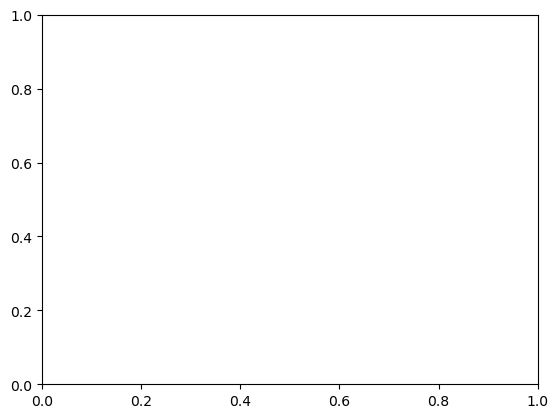

In [29]:
# Plot analytical results
# setup
fig = plt.figure()
ax = plt.axes()

# plot
x=[sols_range[i]['housing'][0]/(sols_range[i]['housing'][0] + sols_range[i]['shelter'][0]) for i in range(len(sols_range))]
ax.plot(x, outputs_range)

# axes
plt.ylim([0, 140])

# Set title 
ax.set_title("True cost of solution for different housing proportions") 
    
# adding labels 
ax.set_xlabel('Proportion of new accommodation which is housing') 
ax.set_ylabel('True cost (unsheltered Q)') 

plt.show()

#### Cost function: quadratic with # unsheltered and # sheltered

In [ ]:
def cost_function(sh,unsh):
    cost = 0.5*(sh**2)+(unsh**2)
    return cost

costs = []
for i in range(len(sols_range)):
    costs.append(cost_function(outputs_range_sh[i],outputs_range_unsh[i]))

In [ ]:
# setup
fig = plt.figure()
ax = plt.axes()

# plot
ax.plot(x, costs)

# axes
#plt.ylim([0, 140])

# Set title 
ax.set_title("True cost of solution for different housing proportions") 
    
# adding labels 
ax.set_xlabel('Proportion of new accommodation which is housing') 
ax.set_ylabel('True cost') 

plt.show()

#### Checking whether the KN algorithm does eventually fail (as it may do due stochasticity)

We now go back to the original solution space which we modelled (i.e. housing and shelter cost the same). We reset the seed and repeatedly optimise with the same indifference-zone parameter (i.e. the true difference between best and second best), but now with alpha = 0.5 - we should see that up to 50% of the optimal solutions found are not the true best. 

In [ ]:
random.seed(1)
spc.optimise_rs(0.05, 
                100, 
                indiff, 
                sim.simulate_as_is, 
                True, 
                False, 
                data_as_is = data_as_is, 
                data_as_is_simulation = data_as_is_simulation)



